In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, LSTM, TimeDistributed, Reshape, Lambda, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.callbacks import TensorBoard
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [14]:
# Read Data
data = pd.read_csv('UrbanSounds8K/metadata/UrbanSound8K.csv')
data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [15]:
data.shape

(8732, 8)

In [16]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

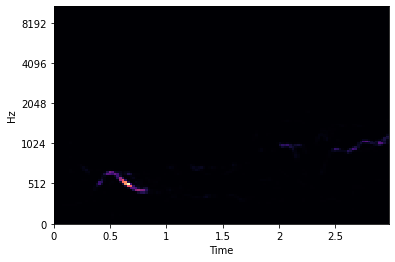

In [17]:
y, sr = librosa.load('UrbanSounds8K/audio/fold9/13579-2-0-16.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

mel_sgram = librosa.amplitude_to_db(ps, ref=np.min)

librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [18]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [6]:
#Use it to create data ######################################################################
def creates_train_data():
    D = [] # Dataset

    for row in valid_data.itertuples():
        y, sr = librosa.load('UrbanSounds8K/augmented/ps2_m25/' + row.path, duration=2.97)  #2.97 = 3*1000 - 3*1000/128  ###############################
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128, 128): continue
        D.append( (ps, row.classID) )
    np.save('train_data_augmented_ps2_m25.npy', D) ###############################
    return D

In [2]:
np.load.__defaults__=(None, True, True, 'ASCII')
a = np.load('train_data.npy')
b = np.load('train_data_augmented_speed_81.npy')
c = np.load('train_data_augmented_speed_107.npy')
d = np.load('train_data_augmented_ps1_2.npy')
e = np.load('train_data_augmented_ps2_m25.npy')

# np.savez('train.npz',a,b,c,d,e) ############################################################################
# r = np.load('train.npz') ############################################################################
# locals().update(r) ############################################################################

tuple = (a,b,c,d,e)
tuplearr = np.vstack(tuple)
len(tuplearr)
dataset = tuplearr
random.shuffle(dataset)
len(dataset)

37303

In [4]:
#To see how many samples are in X-train and y-train
kf = KFold(n_splits=10)

count = 0

keras.backend.clear_session()

def ReshapeLayer(x):
    
    shape = x.shape
    
    # 1 possibility: H,W*channel
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    
    return reshape

for train_set, test_set in kf.split(dataset):
     print( train_set, test_set)
     print("-----------breaking line--------------")
     #X_train, X_test, y_train, y_test = dataset[train_set], dataset[test_set]
 
     print('----------------------------')
     count += 1
     print(count)
     print('----------------------------')
 
     X_train,y_train = zip(*dataset[train_set])
     X_test, y_test = zip(*dataset[test_set])
 
     # Reshape for CNN input
     X_train = np.array([x.reshape( (128, 128) ) for x in X_train])
     X_test = np.array([x.reshape( (128, 128) ) for x in X_test])

    #  X_train = np.expand_dims(X_train, axis=3)
    #  X_test = np.expand_dims(X_test, axis=3)
 
     # One-Hot encoding for classes
     y_train = np.array(keras.utils.to_categorical(y_train, 10))
     y_test = np.array(keras.utils.to_categorical(y_test, 10))

 
     NAME = "graphic-{}-".format(int(time.time()))
     tensorboard = TensorBoard(log_dir='E2-{}'.format(NAME +  str(count)))
 
 
     model = Sequential()

     model.add(
        Conv1D(24, kernel_size=(5), input_shape=(128, 128))
        )

     model.add(MaxPooling1D(8))
     model.add(Activation('relu'))
 
     model.add(Conv1D(48, kernel_size=(1), padding="valid"))
     model.add(MaxPooling1D(8))
     model.add(Activation('relu'))
 
     model.add(Conv1D(48, kernel_size=(1), padding="valid"))
     model.add(Activation('relu'))

     model.add(
        LSTM(units = 100, return_sequences=True)
        ) 
   
     model.add(LSTM(32))
     model.add(Dense(10))
     model.add(Activation('softmax'))
 
     model.compile(
 	    optimizer="Adam",
 	    loss="categorical_crossentropy",
 	    metrics=['accuracy']
        )


     model.fit(
 	    x=X_train, 
 	    y=y_train,
        epochs=12,
        batch_size=128,
        validation_data = (X_test, y_test),
 	      callbacks=[tensorboard]
 	    )
 
     score = model.evaluate(
 	    x=X_test,
 	    y=y_test
        )
 
     print('Test loss:', score[0])
     print('Test accuracy:', score[1])
    

    

    


[ 3731  3732  3733 ... 37300 37301 37302] [   0    1    2 ... 3728 3729 3730]
-----------breaking line--------------
----------------------------
1
----------------------------
Epoch 1/12
  1/263 [..............................] - ETA: 0s - loss: 2.3065 - accuracy: 0.1016WARNING:tensorflow:From C:\Users\Guest1\anaconda3\envs\backup_20220216_20220322\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
263/263 [==============================] - 5s 19ms/step - loss: 1.7931 - accuracy: 0.3260 - val_loss: 1.5529 - val_accuracy: 0.4259
Epoch 2/12
263/263 [==============================] - 4s 16ms/step - loss: 1.5292 - accuracy: 0.4283 - val_loss: 1.3957 - val_accuracy: 0.4940
Epoch 3/12
263/263 [==============================] - 4s 16ms/step - loss: 1.4271 - accuracy: 0.4662 - val_loss: 1.2475 - val_accuracy: 0.52

In [9]:
model.save('SoundClassification1D.model')

INFO:tensorflow:Assets written to: SoundClassification1D.model\assets


In [10]:
model = tf.keras.models.load_model("SoundClassification1DCNNLSTM.model")

In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 